In [1]:
!pip install flwr
!pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.1/330.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached n

In [2]:
!pip install -q flwr[simulation] flwr_datasets[vision] torch torchvision matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [3]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader
from logging import INFO, DEBUG

import flwr as fl
from flwr.common import Metrics
from flwr_datasets import FederatedDataset
from flwr.common.logger import log

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)
disable_progress_bar()

Training on cuda using PyTorch 2.3.0+cu121 and Flower 1.8.0


In [5]:
cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}
class VGG(nn.Module):
    def __init__(self, dimension='VGG16', num_classes=10):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[dimension])
        self.pool = nn.AvgPool2d(kernel_size=1, stride=1)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1, bias=False),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

def create_model(dimension='VGG16'):
    num_classes = 10
    model = VGG(dimension=dimension, num_classes=num_classes)
    return model


In [7]:
NUM_CLIENTS = 5
BATCH_SIZE = 32
from torch.utils.data import DataLoader, TensorDataset
import os


def load_datasets():
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    def apply_transforms(data):
        return torch.stack([transform(img) for img in data])
    
    trainloaders = []
    valloaders = []

    for i in range(NUM_CLIENTS):
        client_path = os.path.join('drive/MyDrive/data', f'client{i}')

        x_train = np.load(os.path.join(client_path, 'trainx.pyp'), allow_pickle=True)
        y_train = np.load(os.path.join(client_path, 'trainy.pyp'), allow_pickle=True)
        x_test = np.load(os.path.join(client_path, 'testx.pyp'), allow_pickle=True)
        y_test = np.load(os.path.join(client_path, 'testy.pyp'), allow_pickle=True)

        x_train = apply_transforms(x_train)
        x_test = apply_transforms(x_test)

        y_train = torch.argmax(torch.tensor(y_train, dtype=torch.float32), dim=1)
        y_test = torch.argmax(torch.tensor(y_test, dtype=torch.float32), dim=1)

        train_dataset = TensorDataset(x_train, y_train)
        test_dataset = TensorDataset(x_test, y_test)

        train_size = int(0.8 * len(train_dataset))
        val_size = len(train_dataset) - train_size
        train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

        trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        trainloaders.append(trainloader)
        valloaders.append(valloader)

    testloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets()

In [8]:
for x_batch, y_batch  in testloader:
  print(y_batch)
  break

tensor([9, 3, 8, 2, 0, 5, 1, 0, 4, 2, 3, 2, 7, 5, 5, 0, 6, 0, 9, 4, 7, 3, 1, 4,
        8, 1, 9, 9, 3, 7, 9, 6])


# FLOWER

In [9]:
def set_parameters(net, parameters: List[np.ndarray]):
    try:
      params_dict = zip(net.state_dict().keys(), parameters)
      state_dict = {k: torch.tensor(v) for k, v in params_dict}
      print(f"State dict keys: {list(state_dict.keys())}")
      net.load_state_dict(state_dict, strict=True)
    except Exception as e:
        print(f"Error in set_parameters: {e}")
        raise e


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

In [11]:
import numpy as np
from sklearn.metrics import cohen_kappa_score, f1_score, accuracy_score, roc_auc_score

def calculate_metrics(y_true, y_pred, y_prob):
    kappa = cohen_kappa_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    accuracy = accuracy_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob, multi_class='ovr')
    return kappa, f1, accuracy, roc

In [10]:
def train(net, trainloader, epochs: int, verbose=False):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    log(INFO, f"In train loop")
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for x_batch, y_batch in trainloader:
            images, labels = x_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")

def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    with torch.no_grad():
        for x_batch, y_batch  in testloader:
            images, labels = x_batch.to(DEVICE), y_batch.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())
            correct += (predicted == labels).sum().item()

    loss /= len(testloader.dataset)
    accuracy = float(correct) / len(testloader.dataset)
    kappa, f1, accuracy, roc = calculate_metrics(all_targets, all_preds, all_probs)

    return loss, accuracy


In [38]:
trainloader = trainloaders[0]
valloader = valloaders[0]
net = create_model().to(DEVICE)
metrics = []

for epoch in range(50):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")
    metrics.append(eval(net, testloader))

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

INFO :      In train loop
INFO:flwr:In train loop
INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.07112182676792145, accuracy 0.1565
Epoch 1: validation loss 0.06734722256660461, accuracy 0.222


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.06877300888299942, accuracy 0.1805
Epoch 2: validation loss 0.08144916987419129, accuracy 0.166


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.06722766906023026, accuracy 0.183
Epoch 3: validation loss 0.06346776008605957, accuracy 0.2


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.06477634608745575, accuracy 0.2015
Epoch 4: validation loss 0.06460116791725158, accuracy 0.234


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.0638931468129158, accuracy 0.212
Epoch 5: validation loss 0.06790145373344421, accuracy 0.218


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.0620575025677681, accuracy 0.2235
Epoch 6: validation loss 0.058873775720596315, accuracy 0.298


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.061119820922613144, accuracy 0.2485
Epoch 7: validation loss 0.059252943754196166, accuracy 0.242


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.05909941717982292, accuracy 0.27
Epoch 8: validation loss 0.057759336471557614, accuracy 0.322


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.059662483632564545, accuracy 0.2665
Epoch 9: validation loss 0.05770147728919983, accuracy 0.304


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.057893432676792145, accuracy 0.272
Epoch 10: validation loss 0.060364306211471555, accuracy 0.294


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.056540608406066895, accuracy 0.3025
Epoch 11: validation loss 0.05872397828102112, accuracy 0.286


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.05557738244533539, accuracy 0.336
Epoch 12: validation loss 0.05637949466705322, accuracy 0.32


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.05477967485785484, accuracy 0.3435
Epoch 13: validation loss 0.056080002069473264, accuracy 0.334


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.05363726243376732, accuracy 0.349
Epoch 14: validation loss 0.05227428865432739, accuracy 0.378


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.0524858795106411, accuracy 0.3645
Epoch 15: validation loss 0.05548601388931274, accuracy 0.342


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.05061957612633705, accuracy 0.3815
Epoch 16: validation loss 0.0546644401550293, accuracy 0.362


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.049083538353443146, accuracy 0.412
Epoch 17: validation loss 0.05012751221656799, accuracy 0.394


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.04754697158932686, accuracy 0.4325
Epoch 18: validation loss 0.05268922138214111, accuracy 0.352


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.04619970917701721, accuracy 0.4345
Epoch 19: validation loss 0.0485067458152771, accuracy 0.376


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.04452237859368324, accuracy 0.478
Epoch 20: validation loss 0.04978087568283081, accuracy 0.448


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.043262772262096405, accuracy 0.5015
Epoch 21: validation loss 0.04768660998344421, accuracy 0.436


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.04202847182750702, accuracy 0.4965
Epoch 22: validation loss 0.048044599294662475, accuracy 0.454


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.03927548602223396, accuracy 0.5415
Epoch 23: validation loss 0.048106643676757814, accuracy 0.448


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.03765207901597023, accuracy 0.5535
Epoch 24: validation loss 0.051029186487197876, accuracy 0.428


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.03613099455833435, accuracy 0.577
Epoch 25: validation loss 0.05040525269508362, accuracy 0.468


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.03490240126848221, accuracy 0.5925
Epoch 26: validation loss 0.046187522649765014, accuracy 0.478


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.03243837505578995, accuracy 0.6285
Epoch 27: validation loss 0.04601512241363526, accuracy 0.504


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.03046204335987568, accuracy 0.64
Epoch 28: validation loss 0.052656579971313476, accuracy 0.448


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.029430413618683815, accuracy 0.6605
Epoch 29: validation loss 0.04822693181037903, accuracy 0.46


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.028534511104226112, accuracy 0.662
Epoch 30: validation loss 0.05437341642379761, accuracy 0.426


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.02571193315088749, accuracy 0.6955
Epoch 31: validation loss 0.05147786569595337, accuracy 0.498


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.024348735809326172, accuracy 0.708
Epoch 32: validation loss 0.053672624111175536, accuracy 0.506


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.023574113845825195, accuracy 0.729
Epoch 33: validation loss 0.052773481369018556, accuracy 0.508


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.022350391373038292, accuracy 0.742
Epoch 34: validation loss 0.055107220649719235, accuracy 0.452


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.020535968244075775, accuracy 0.7655
Epoch 35: validation loss 0.0550581476688385, accuracy 0.51


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.020661568269133568, accuracy 0.7645
Epoch 36: validation loss 0.06747810268402099, accuracy 0.462


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.018536049872636795, accuracy 0.793
Epoch 37: validation loss 0.057031466722488405, accuracy 0.522


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.01804206147789955, accuracy 0.8025
Epoch 38: validation loss 0.053072442531585697, accuracy 0.514


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.016397710889577866, accuracy 0.8155
Epoch 39: validation loss 0.06262896132469177, accuracy 0.5


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.015901554375886917, accuracy 0.8245
Epoch 40: validation loss 0.06722903180122375, accuracy 0.472


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.015160297974944115, accuracy 0.8255
Epoch 41: validation loss 0.06032231903076172, accuracy 0.504


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.012861030176281929, accuracy 0.854
Epoch 42: validation loss 0.06137160420417786, accuracy 0.51


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.012702262960374355, accuracy 0.86
Epoch 43: validation loss 0.06413461899757385, accuracy 0.562


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.01290103793144226, accuracy 0.8685
Epoch 44: validation loss 0.06117067384719849, accuracy 0.538


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.011808240786194801, accuracy 0.8645
Epoch 45: validation loss 0.07303365921974182, accuracy 0.492


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.011798138730227947, accuracy 0.8625
Epoch 46: validation loss 0.0688658094406128, accuracy 0.494


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.011185115203261375, accuracy 0.871
Epoch 47: validation loss 0.06242788314819336, accuracy 0.542


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.010976689867675304, accuracy 0.887
Epoch 48: validation loss 0.07180458784103394, accuracy 0.496


INFO :      In train loop
INFO:flwr:In train loop


Epoch 1: train loss 0.00964380707591772, accuracy 0.8955
Epoch 49: validation loss 0.07075906276702881, accuracy 0.526
Epoch 1: train loss 0.009643372148275375, accuracy 0.896
Epoch 50: validation loss 0.07204121136665344, accuracy 0.524
Final test set performance:
	loss 0.0749219090938568
	accuracy 0.51


In [39]:
metrics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'accuracy': 0.162,
  'kappa': 0.08270538423479235,
  'f1': 0.0703212543554007,
  'roc': 0.7454804163148119},
 {'accuracy': 0.182,
  'kappa': 0.08454424180566356,
  'f1': 0.08589481869174258,
  'roc': 0.6629454377598983},
 {'accuracy': 0.192,
  'kappa': 0.09380060921721434,
  'f1': 0.11575636807869726,
  'roc': 0.738540133665909},
 {'accuracy': 0.198,
  'kappa': 0.11968352512963265,
  'f1': 0.12051731828143963,
  'roc': 0.7378072416410464},
 {'accuracy': 0.198,
  'kappa': 0.11392181299109949,
  'f1': 0.12868884151261545,
  'roc': 0.7323514449824635},
 {'accuracy': 0.266,
  'kappa': 0.1858267297299695,
  'f1': 0.21410512042112997,
  'roc': 0.7782119524314617},
 {'accuracy': 0.254,
  'kappa': 0.16804211089797927,
  'f1': 0.17660345468519137,
  'roc': 0.7760002219194367},
 {'accuracy': 0.25,
  'kappa': 0.16965590540720077,
  'f1': 0.17985060133910577,
  'roc': 0.7823990491018455},
 {'accuracy': 0.288,
  'kappa': 0.20719051479168704,
  'f1': 0.24602346734932803,
  'roc': 0.787703121380205

In [13]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=3)
        return get_parameters(self.net), len(self.trainloader), {}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""

    # Load model
    flowerNet = create_model().to(DEVICE)

    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]

    return FlowerClient(flowerNet, trainloader, valloader).to_client()

In [15]:
client_resources = {"num_cpus": 1, "num_gpus": 0.0}
if DEVICE.type == "cuda":
    # here we are assigning an entire GPU for each client.
    client_resources = {"num_cpus": 1, "num_gpus": 1.0}


In [16]:
def weighted_average(metrics: List[Tuple[int, Metrics]]) -> Metrics:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]

    return {"accuracy": sum(accuracies) / sum(examples)}

In [17]:
import gc
class CustomFedAvg(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round,
        results,
        failures,
    ):
        """Aggregate model weights using weighted average and store checkpoint"""

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...")
            flowerNet = create_model()

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(flowerNet.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            flowerNet.load_state_dict(state_dict, strict=True)

            # Save the model
            torch.save(flowerNet.state_dict(), f"model_round_{server_round}.pth")
            del params_dict
            del state_dict
            gc.collect()
        return aggregated_parameters, aggregated_metrics

In [18]:
# Create FedAvg strategy
strategy = CustomFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=0.5,
    min_fit_clients=5,
    min_evaluate_clients=2,
    min_available_clients=5,
    evaluate_metrics_aggregation_fn=weighted_average,  # <-- pass the metric aggregation function
)

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=50),
    strategy=strategy,
    client_resources=client_resources,
)

INFO :      Starting Flower simulation, config: num_rounds=50, no round_timeout
INFO:flwr:Starting Flower simulation, config: num_rounds=50, no round_timeout
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-06-07 17:05:47,221	INFO worker.py:1621 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'memory': 33830021531.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 16915010764.0, 'node:__internal_head__': 1.0, 'accelerator_type:L4': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'CPU': 12.0, 'memory': 33830021531.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0, 'object_store_memory': 16915010764.0, 'node:__internal_head__': 1.0, 'accelerator_type:L4': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/d

(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.07381220906972885, accuracy 0.141
(ClientAppActor pid=3873) Epoch 2: train loss 0.0638704001903534, accuracy 0.231
(ClientAppActor pid=3873) Epoch 3: train loss 0.05806829407811165, accuracy 0.2815


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.07018128782510757, accuracy 0.171
(ClientAppActor pid=3873) Epoch 2: train loss 0.06266594678163528, accuracy 0.2335


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.059003449976444244, accuracy 0.2565


Saving round 1 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 2]
INFO:flwr:[ROUND 2]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.06723107397556305, accuracy 0.1995
(ClientAppActor pid=3873) Epoch 2: train loss 0.060821954160928726, accuracy 0.245
(ClientAppActor pid=3873) Epoch 3: train loss 0.05671171471476555, accuracy 0.2645


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.055906929075717926, accuracy 0.28
Saving round 2 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 3]
INFO:flwr:[ROUND 3]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.06027994677424431, accuracy 0.261
(ClientAppActor pid=3873) Epoch 2: train loss 0.05510187894105911, accuracy 0.301
(ClientAppActor pid=3873) Epoch 3: train loss 0.053399186581373215, accuracy 0.3275


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.05416703224182129, accuracy 0.3055
Saving round 3 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 4]
INFO:flwr:[ROUND 4]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.05072436481714249, accuracy 0.3525
Saving round 4 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 5]
INFO:flwr:[ROUND 5]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.05150607228279114, accuracy 0.352
(ClientAppActor pid=3873) Epoch 2: train loss 0.048860471695661545, accuracy 0.387
(ClientAppActor pid=3873) Epoch 3: train loss 0.04721185192465782, accuracy 0.4195


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.04656950756907463, accuracy 0.4125
Saving round 5 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 6]
INFO:flwr:[ROUND 6]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.049417395144701004, accuracy 0.3925
(ClientAppActor pid=3873) Epoch 2: train loss 0.04558886960148811, accuracy 0.4355
(ClientAppActor pid=3873) Epoch 3: train loss 0.04369491711258888, accuracy 0.4615


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.044257037341594696, accuracy 0.4605
Saving round 6 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 7]
INFO:flwr:[ROUND 7]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.04414330795407295, accuracy 0.479
(ClientAppActor pid=3873) Epoch 2: train loss 0.040234364569187164, accuracy 0.527
(ClientAppActor pid=3873) Epoch 3: train loss 0.038302116096019745, accuracy 0.55


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.040120929479599, accuracy 0.527
Saving round 7 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 8]
INFO:flwr:[ROUND 8]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.035056907683610916, accuracy 0.578
Saving round 8 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 9]
INFO:flwr:[ROUND 9]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.03930545225739479, accuracy 0.549
(ClientAppActor pid=3873) Epoch 2: train loss 0.03368942812085152, accuracy 0.6005


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.03212669864296913, accuracy 0.6225
Saving round 9 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 10]
INFO:flwr:[ROUND 10]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.03472613915801048, accuracy 0.602
(ClientAppActor pid=3873) Epoch 2: train loss 0.029516780748963356, accuracy 0.6535
(ClientAppActor pid=3873) Epoch 3: train loss 0.02839013934135437, accuracy 0.679


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.027979381382465363, accuracy 0.6725
Saving round 10 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 11]
INFO:flwr:[ROUND 11]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.03383353725075722, accuracy 0.6005
(ClientAppActor pid=3873) Epoch 2: train loss 0.02924206852912903, accuracy 0.675
(ClientAppActor pid=3873) Epoch 3: train loss 0.028144221752882004, accuracy 0.672


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.031528595834970474, accuracy 0.6285
(ClientAppActor pid=3873) Epoch 2: train loss 0.028071589767932892, accuracy 0.6775


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.02513509802520275, accuracy 0.7075
Saving round 11 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 12]
INFO:flwr:[ROUND 12]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.02346896566450596, accuracy 0.738
Saving round 12 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 13]
INFO:flwr:[ROUND 13]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.027043325826525688, accuracy 0.7005
(ClientAppActor pid=3873) Epoch 2: train loss 0.021601412445306778, accuracy 0.7545
(ClientAppActor pid=3873) Epoch 3: train loss 0.02030191756784916, accuracy 0.768


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.02972920425236225, accuracy 0.651
(ClientAppActor pid=3873) Epoch 2: train loss 0.02486073225736618, accuracy 0.718


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.020968275144696236, accuracy 0.753
Saving round 13 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 14]
INFO:flwr:[ROUND 14]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.025705799460411072, accuracy 0.7105
(ClientAppActor pid=3873) Epoch 2: train loss 0.020375875756144524, accuracy 0.772
(ClientAppActor pid=3873) Epoch 3: train loss 0.01803809218108654, accuracy 0.8


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.017558543011546135, accuracy 0.7965
Saving round 14 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 15]
INFO:flwr:[ROUND 15]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.02351570688188076, accuracy 0.7345
(ClientAppActor pid=3873) Epoch 2: train loss 0.01867636851966381, accuracy 0.7855
(ClientAppActor pid=3873) Epoch 3: train loss 0.01656375639140606, accuracy 0.817


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.02417660877108574, accuracy 0.715
(ClientAppActor pid=3873) Epoch 2: train loss 0.018871387466788292, accuracy 0.7825
(ClientAppActor pid=3873) Epoch 3: train loss 0.016799557954072952, accuracy 0.803


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.015700677409768105, accuracy 0.8255
Saving round 15 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 16]
INFO:flwr:[ROUND 16]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.022157208994030952, accuracy 0.7495
(ClientAppActor pid=3873) Epoch 2: train loss 0.015585838817059994, accuracy 0.8255


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.015595778822898865, accuracy 0.824
Saving round 16 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 17]
INFO:flwr:[ROUND 17]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.021999621763825417, accuracy 0.76
(ClientAppActor pid=3873) Epoch 2: train loss 0.016229169443249702, accuracy 0.819
(ClientAppActor pid=3873) Epoch 3: train loss 0.013513064943253994, accuracy 0.8455
(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.runn

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.020267317071557045, accuracy 0.7665
(ClientAppActor pid=3873) Epoch 2: train loss 0.017142467200756073, accuracy 0.8095
(ClientAppActor pid=3873) Epoch 3: train loss 0.013422599993646145, accuracy 0.845


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.01276183221489191, accuracy 0.8565
Saving round 17 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 18]
INFO:flwr:[ROUND 18]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.012108051218092442, accuracy 0.8665
Saving round 18 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 19]
INFO:flwr:[ROUND 19]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.01748366467654705, accuracy 0.7925
(ClientAppActor pid=3873) Epoch 2: train loss 0.013926479034125805, accuracy 0.8415
(ClientAppActor pid=3873) Epoch 3: train loss 0.010561338625848293, accuracy 0.878
(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.run

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.0165364108979702, accuracy 0.817
(ClientAppActor pid=3873) Epoch 2: train loss 0.011403970420360565, accuracy 0.878
(ClientAppActor pid=3873) Epoch 3: train loss 0.0112548703327775, accuracy 0.8735
(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.018164049834012985, accuracy 0.808
(ClientAppActor pid=3873) Epoch 2: train loss 0.013281704857945442, accuracy 0.849
(ClientAppActor pid=3873) Epoch 3: train loss 0.009906384162604809, accuracy 0.8875


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.009745349176228046, accuracy 0.888
Saving round 19 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 20]
INFO:flwr:[ROUND 20]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.018196433782577515, accuracy 0.792
(ClientAppActor pid=3873) Epoch 2: train loss 0.010645768605172634, accuracy 0.8875
(ClientAppActor pid=3873) Epoch 3: train loss 0.01080985926091671, accuracy 0.884


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.009299760684370995, accuracy 0.8925
Saving round 20 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 21]
INFO:flwr:[ROUND 21]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.014701241627335548, accuracy 0.8365
(ClientAppActor pid=3873) Epoch 2: train loss 0.010797695256769657, accuracy 0.884
(ClientAppActor pid=3873) Epoch 3: train loss 0.008560352958738804, accuracy 0.9155


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.009109368547797203, accuracy 0.8985
Saving round 21 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 22]
INFO:flwr:[ROUND 22]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.013637783005833626, accuracy 0.854
(ClientAppActor pid=3873) Epoch 2: train loss 0.009673305787146091, accuracy 0.8905
(ClientAppActor pid=3873) Epoch 3: train loss 0.007461929693818092, accuracy 0.911


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.013606516644358635, accuracy 0.85
(ClientAppActor pid=3873) Epoch 2: train loss 0.008900303393602371, accuracy 0.899


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.00897326972335577, accuracy 0.8985
Saving round 22 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 23]
INFO:flwr:[ROUND 23]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.01212269440293312, accuracy 0.8625
(ClientAppActor pid=3873) Epoch 2: train loss 0.009709320962429047, accuracy 0.886
(ClientAppActor pid=3873) Epoch 3: train loss 0.007399892900139093, accuracy 0.9205


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.012850480154156685, accuracy 0.8565
(ClientAppActor pid=3873) Epoch 2: train loss 0.0067136469297111034, accuracy 0.9265
(ClientAppActor pid=3873) Epoch 3: train loss 0.007202205713838339, accuracy 0.9215


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.007712936028838158, accuracy 0.9135
Saving round 23 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 24]
INFO:flwr:[ROUND 24]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.0071731978096067905, accuracy 0.9175
Saving round 24 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 25]
INFO:flwr:[ROUND 25]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.005360164679586887, accuracy 0.9445
Saving round 25 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 26]
INFO:flwr:[ROUND 26]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.01017981767654419, accuracy 0.8855
(ClientAppActor pid=3873) Epoch 2: train loss 0.006405931897461414, accuracy 0.9385


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.0051344637759029865, accuracy 0.9465
Saving round 26 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 27]
INFO:flwr:[ROUND 27]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.005342093296349049, accuracy 0.94
Saving round 27 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 28]
INFO:flwr:[ROUND 28]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.00873660296201706, accuracy 0.905
(ClientAppActor pid=3873) Epoch 2: train loss 0.006096967030316591, accuracy 0.933
(ClientAppActor pid=3873) Epoch 3: train loss 0.005538955796509981, accuracy 0.9415


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.004475935362279415, accuracy 0.9515
Saving round 28 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 29]
INFO:flwr:[ROUND 29]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.0033786685671657324, accuracy 0.962
Saving round 29 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 30]
INFO:flwr:[ROUND 30]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.0075019304640591145, accuracy 0.9275
(ClientAppActor pid=3873) Epoch 2: train loss 0.004690356086939573, accuracy 0.955
(ClientAppActor pid=3873) Epoch 3: train loss 0.0041386703960597515, accuracy 0.954


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.003759325947612524, accuracy 0.96
Saving round 30 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 31]
INFO:flwr:[ROUND 31]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.006296662148088217, accuracy 0.9365
(ClientAppActor pid=3873) Epoch 2: train loss 0.006794760935008526, accuracy 0.9265


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.004358224105089903, accuracy 0.9585
Saving round 31 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 32]
INFO:flwr:[ROUND 32]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.003120403503999114, accuracy 0.9705
Saving round 32 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 33]
INFO:flwr:[ROUND 33]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.005797208286821842, accuracy 0.9325
(ClientAppActor pid=3873) Epoch 2: train loss 0.004852231126278639, accuracy 0.955
(ClientAppActor pid=3873) Epoch 3: train loss 0.0032703636679798365, accuracy 0.964


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.0025831088423728943, accuracy 0.973
Saving round 33 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 34]
INFO:flwr:[ROUND 34]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.005657666828483343, accuracy 0.942
(ClientAppActor pid=3873) Epoch 2: train loss 0.004076365381479263, accuracy 0.96
(ClientAppActor pid=3873) Epoch 3: train loss 0.0036992272362113, accuracy 0.9615


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.004167019389569759, accuracy 0.955
Saving round 34 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 35]
INFO:flwr:[ROUND 35]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.004929869901388884, accuracy 0.9515
(ClientAppActor pid=3873) Epoch 2: train loss 0.0050570424646139145, accuracy 0.9505


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.00241876975633204, accuracy 0.974
Saving round 35 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 36]
INFO:flwr:[ROUND 36]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.006183123681694269, accuracy 0.9385
(ClientAppActor pid=3873) Epoch 2: train loss 0.0037069732788950205, accuracy 0.966
(ClientAppActor pid=3873) Epoch 3: train loss 0.0020583809819072485, accuracy 0.98
(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.ru

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.005055425688624382, accuracy 0.9505
(ClientAppActor pid=3873) Epoch 2: train loss 0.0043049342930316925, accuracy 0.956
(ClientAppActor pid=3873) Epoch 3: train loss 0.0027717044577002525, accuracy 0.9705


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.0031726656015962362, accuracy 0.97
Saving round 36 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 37]
INFO:flwr:[ROUND 37]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.003917182330042124, accuracy 0.9565
Saving round 37 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 38]
INFO:flwr:[ROUND 38]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.003928883466869593, accuracy 0.9615
(ClientAppActor pid=3873) Epoch 2: train loss 0.0042478591203689575, accuracy 0.9565


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.00255434587597847, accuracy 0.975
Saving round 38 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 39]
INFO:flwr:[ROUND 39]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.0026640810538083315, accuracy 0.972
Saving round 39 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 40]
INFO:flwr:[ROUND 40]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.003733583027496934, accuracy 0.9655
(ClientAppActor pid=3873) Epoch 2: train loss 0.0031422229949384928, accuracy 0.9645


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.00286237895488739, accuracy 0.97
Saving round 40 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 41]
INFO:flwr:[ROUND 41]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.0034852183889597654, accuracy 0.965
(ClientAppActor pid=3873) Epoch 2: train loss 0.002962329890578985, accuracy 0.9705
(ClientAppActor pid=3873) Epoch 3: train loss 0.003209651680663228, accuracy 0.964


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.001726063434034586, accuracy 0.9835
Saving round 41 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 42]
INFO:flwr:[ROUND 42]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.003358596470206976, accuracy 0.966
(ClientAppActor pid=3873) Epoch 2: train loss 0.002217554720118642, accuracy 0.9775
(ClientAppActor pid=3873) Epoch 3: train loss 0.003098889486864209, accuracy 0.972


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.0044070701114833355, accuracy 0.953
Saving round 42 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 43]
INFO:flwr:[ROUND 43]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.0032946926075965166, accuracy 0.967
(ClientAppActor pid=3873) Epoch 2: train loss 0.0025829130318015814, accuracy 0.971


INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.001733437879011035, accuracy 0.979
Saving round 43 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 44]
INFO:flwr:[ROUND 44]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.0026356223970651627, accuracy 0.976
(ClientAppActor pid=3873) Epoch 2: train loss 0.003730838419869542, accuracy 0.9595
(ClientAppActor pid=3873) Epoch 3: train loss 0.00163400883320719, accuracy 0.981


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.0038701000157743692, accuracy 0.963
Saving round 44 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 45]
INFO:flwr:[ROUND 45]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.0026623934973031282, accuracy 0.9765
(ClientAppActor pid=3873) Epoch 2: train loss 0.0032594737131148577, accuracy 0.9705
(ClientAppActor pid=3873) Epoch 3: train loss 0.0016949138371273875, accuracy 0.981


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.0031490919645875692, accuracy 0.971
Saving round 45 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 46]
INFO:flwr:[ROUND 46]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.0017159575363621116, accuracy 0.985
Saving round 46 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 47]
INFO:flwr:[ROUND 47]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.0024498379789292812, accuracy 0.9755
Saving round 47 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 48]
INFO:flwr:[ROUND 48]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.003567214822396636, accuracy 0.963
Saving round 48 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 49]
INFO:flwr:[ROUND 49]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.0021263500675559044, accuracy 0.9765
(ClientAppActor pid=3873) Epoch 2: train loss 0.0036193043924868107, accuracy 0.9645
(ClientAppActor pid=3873) Epoch 3: train loss 0.0025373492389917374, accuracy 0.9775
(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.1

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.002782928990200162, accuracy 0.976
(ClientAppActor pid=3873) Epoch 2: train loss 0.0017034414922818542, accuracy 0.981
(ClientAppActor pid=3873) Epoch 3: train loss 0.002431511413305998, accuracy 0.977


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.0027697994373738766, accuracy 0.9665
Saving round 49 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [ROUND 50]
INFO:flwr:[ROUND 50]
INFO :      configure_fit: strategy sampled 5 clients (out of 5)
INFO:flwr:configure_fit: strategy sampled 5 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.0024374648928642273, accuracy 0.972
(ClientAppActor pid=3873) Epoch 2: train loss 0.001980181783437729, accuracy 0.98
(ClientAppActor pid=3873) Epoch 3: train loss 0.001458575134165585, accuracy 0.9835
(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.run

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) Epoch 1: train loss 0.0017681049648672342, accuracy 0.982
(ClientAppActor pid=3873) Epoch 2: train loss 0.004086822271347046, accuracy 0.965
(ClientAppActor pid=3873) Epoch 3: train loss 0.0033205547370016575, accuracy 0.971


(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

(ClientAppActor pid=3873) INFO :      In train loop


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_fit: received 5 results and 0 failures
INFO:flwr:aggregate_fit: received 5 results and 0 failures


(ClientAppActor pid=3873) Epoch 3: train loss 0.003558484371751547, accuracy 0.968
Saving round 50 aggregated_parameters...


INFO :      configure_evaluate: strategy sampled 2 clients (out of 5)
INFO:flwr:configure_evaluate: strategy sampled 2 clients (out of 5)


(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO :      aggregate_evaluate: received 2 results and 0 failures
INFO:flwr:aggregate_evaluate: received 2 results and 0 failures
INFO :      
INFO:flwr:
INFO :      [SUMMARY]
INFO:flwr:[SUMMARY]
INFO :      Run finished 50 rounds in 866.45s
INFO:flwr:Run finished 50 rounds in 866.45s
INFO :      History (loss, distributed):
INFO:flwr:History (loss, distributed):
INFO :      	('\tround 1: 0.0742765598297119\n'
INFO:flwr:	('\tround 1: 0.0742765598297119\n'
INFO :      	 '\tround 2: 0.08139770603179931\n'
INFO:flwr:	 '\tround 2: 0.08139770603179931\n'
INFO :      	 '\tround 3: 0.06599370217323303\n'
INFO:flwr:	 '\tround 3: 0.06599370217323303\n'
INFO :      	 '\tround 4: 0.04851337444782257\n'
INFO:flwr:	 '\tround 4: 0.04851337444782257\n'
INFO :      	 '\tround 5: 0.04518650901317596\n'
INFO:flwr:	 '\tround 5: 0.04518650901317596\n'
INFO :      	 '\tround 6: 0.04374644327163696\n'
INFO:flwr:	 '\tround 6: 0.04374644327163696\n'
INFO :      	 '\tround 7: 0.04108831089735031\n'
INFO:flwr:	

(ClientAppActor pid=3873) State dict keys: ['features.0.weight', 'features.1.weight', 'features.1.bias', 'features.1.running_mean', 'features.1.running_var', 'features.1.num_batches_tracked', 'features.3.weight', 'features.4.weight', 'features.4.bias', 'features.4.running_mean', 'features.4.running_var', 'features.4.num_batches_tracked', 'features.7.weight', 'features.8.weight', 'features.8.bias', 'features.8.running_mean', 'features.8.running_var', 'features.8.num_batches_tracked', 'features.10.weight', 'features.11.weight', 'features.11.bias', 'features.11.running_mean', 'features.11.running_var', 'features.11.num_batches_tracked', 'features.14.weight', 'features.15.weight', 'features.15.bias', 'features.15.running_mean', 'features.15.running_var', 'features.15.num_batches_tracked', 'features.17.weight', 'features.18.weight', 'features.18.bias', 'features.18.running_mean', 'features.18.running_var', 'features.18.num_batches_tracked', 'features.20.weight', 'features.21.weight', 'featu

INFO:flwr:	              (7, 0.527),
INFO :      	              (8, 0.584),
INFO:flwr:	              (8, 0.584),
INFO :      	              (9, 0.613),
INFO:flwr:	              (9, 0.613),
INFO :      	              (10, 0.621),
INFO:flwr:	              (10, 0.621),
INFO :      	              (11, 0.633),
INFO:flwr:	              (11, 0.633),
INFO :      	              (12, 0.668),
INFO:flwr:	              (12, 0.668),
INFO :      	              (13, 0.685),
INFO:flwr:	              (13, 0.685),
INFO :      	              (14, 0.69),
INFO:flwr:	              (14, 0.69),
INFO :      	              (15, 0.687),
INFO:flwr:	              (15, 0.687),
INFO :      	              (16, 0.6930000000000001),
INFO:flwr:	              (16, 0.6930000000000001),
INFO :      	              (17, 0.698),
INFO:flwr:	              (17, 0.698),
INFO :      	              (18, 0.716),
INFO:flwr:	              (18, 0.716),
INFO :      	              (19, 0.715),
INFO:flwr:	              (19, 0.715),
INFO : 

History (loss, distributed):
('\tround 1: 0.0742765598297119\n'
 '\tround 2: 0.08139770603179931\n'
 '\tround 3: 0.06599370217323303\n'
 '\tround 4: 0.04851337444782257\n'
 '\tround 5: 0.04518650901317596\n'
 '\tround 6: 0.04374644327163696\n'
 '\tround 7: 0.04108831089735031\n'
 '\tround 8: 0.036226625978946686\n'
 '\tround 9: 0.03363972282409668\n'
 '\tround 10: 0.032421798884868624\n'
 '\tround 11: 0.031026312172412873\n'
 '\tround 12: 0.029564564645290375\n'
 '\tround 13: 0.030593918710947035\n'
 '\tround 14: 0.028532607853412627\n'
 '\tround 15: 0.03227246278524398\n'
 '\tround 16: 0.034205977022647854\n'
 '\tround 17: 0.03179763954877853\n'
 '\tround 18: 0.03201353216171265\n'
 '\tround 19: 0.03222234877943993\n'
 '\tround 20: 0.03158512854576111\n'
 '\tround 21: 0.035918511241674424\n'
 '\tround 22: 0.03368892273306846\n'
 '\tround 23: 0.038456057429313656\n'
 '\tround 24: 0.03824699735641479\n'
 '\tround 25: 0.04056576898694038\n'
 '\tround 26: 0.03927983605861664\n'
 '\tround 

In [19]:
def eval(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    all_preds = []
    all_targets = []
    all_probs = []
    with torch.no_grad():
        for x_batch, y_batch  in testloader:
            images, labels = x_batch.to(DEVICE), y_batch.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())
            all_probs.extend(F.softmax(outputs, dim=1).cpu().numpy())
            correct += (predicted == labels).sum().item()

    loss /= len(testloader.dataset)
    accuracy = float(correct) / len(testloader.dataset)
    kappa, f1, accuracy, roc = calculate_metrics(all_targets, all_preds, all_probs)

    return {"accuracy": accuracy, "kappa": kappa, "f1": f1, "roc": roc}

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [20]:
model = create_model()

# Load the saved state_dict
flower_metrics = []
base_metrics = []
for i in range(50):
  model.load_state_dict(torch.load(f"model_round_{i+1}.pth"))
  model.to(DEVICE)
  flower_metrics.append(eval(model, testloader))
base_metrics.append(eval(net, testloader))



In [21]:
base_metrics

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'accuracy': 0.466,
  'kappa': 0.4068775546472365,
  'f1': 0.4635940000398746,
  'roc': 0.8654574075149378}]

In [22]:
import matplotlib.pyplot as plt

rounds = [1]
accuracy = [metric['accuracy'] for metric in flower_metrics]
kappa = [metric['kappa'] for metric in flower_metrics]
f1 = [metric['f1'] for metric in flower_metrics]
roc = [metric['roc'] for metric in flower_metrics]

for i in range(49):
  rounds.append(i + 2)
  base_metrics.append(base_metrics[0])


In [32]:
# These were imported from FEDn studio after the training to compute the plots here
fedn_accuracy = [0.923799991607666, 0.9214000105857849,0.9223999977111816]
fedn_kappa = [0.9152881762838376, 0.912619807582146,0.913730283423145]
fedn_f1 = [0.9229572492898998, 0.9206198873055295,0.9216334819423526]
fedn_roc = [0.9954329697271828, 0.9953738361175626,0.9952913628926933]

vals = [0.920799970626831,0.9119534409795901,0.9200011387656897,0.9952087267250864,0.9190000295639038,0.9099526470986877,0.9181888187034295,0.995114430616676,0.9187999963760376,0.909729685766368,0.9179396882585629,0.9950446868919265,0.9193999767303467,0.9103957236125634,0.9185773447561415,0.9949347980194487,0.9179999828338623,0.9088408216670337,0.917121967668088,0.99482772693027,0.9190000295639038,0.9099514658411669,0.9181305691982379,0.9947386437953863,0.9161999821662903,0.9068389711393804,0.9152511926722162,0.9945961934583959,0.9161999821662903,0.9068378194517831,0.9152410718581306,0.9944624332910464,0.9146000146865845,0.9050595774497509,0.9135918325567278,0.9943252624269616,0.9142000079154968,0.9046168766762915,0.9131978343411694,0.994211689373565,0.9125999808311462,0.9028382006577476,0.9115087024987034,0.9940938822522835,0.9128000140190125,0.9030589783839309,0.9117786022509003,0.9939267956944533,0.9115999937057495,0.9017257754258764,0.9105535218212735,0.9937881726935359,0.9103999733924866,0.9003915324264694,0.9093358165137466,0.9936355110687671,0.909600019454956,0.8995023677420032,0.9085448707341703,0.993476790847402,0.9074000120162964,0.897053566342395,0.9062815040886889,0.9932909153483802,0.9065999984741211,0.8961681096557255,0.9054771251775442,0.9931293167909466,0.9046000242233276,0.8939437760604821,0.9035275918936531,0.992988828351921,0.9034000039100647,0.8926118796340586,0.9022815972786715,0.9927848462977942,0.9020000100135803,0.8910533306397567,0.9008624730977507,0.9925333125154407,0.9007999897003174,0.8897193731578023,0.8995608877956709,0.9923335472446307,0.8996000289916992,0.8883859289074396,0.8983500596156283,0.99209106470488,0.897599995136261,0.8861604149168277,0.896305230010559,0.9918061832344097,0.8970000147819519,0.8854930500284645,0.895681698780262,0.9915656570284741,0.8960000276565552,0.8843837022108371,0.8946870008210783,0.9912721238638019,0.8948000073432922,0.8830495119896262,0.8934022285169313,0.9909490446940016,0.892799973487854,0.8808256947272797,0.891335883982876,0.9906281343185934,0.8895999789237976,0.877267925319667,0.8880379550943818,0.9902377014965728,0.8871999979019165,0.8746028478760457,0.8854848363063466,0.9898035309053068,0.8844000101089478,0.8714871181622142,0.8826165690188903,0.989449188416847,0.8831999897956848,0.8701534093001109,0.8812629549892416,0.9889085909264773,0.8802000284194946,0.8668172247173179,0.8782610755119945,0.988425305494378,0.876800000667572,0.8630335150318271,0.874683139293308,0.9878314285422081,0.8723999857902527,0.8581447566499981,0.8702893591414677,0.9872383058650236,0.8695999979972839,0.8550300245715214,0.8674631371336939,0.9865440022974787,0.8673999905586243,0.8525847103173937,0.8651454704940535,0.9857512119721035,0.8619999885559082,0.8465780433257379,0.8596849138157795,0.9847654155250029,0.857200026512146,0.841243279465592,0.8547458884591554,0.9835883460745565,0.848800003528595,0.8318959697547941,0.8460937074720638,0.9821766190959181,0.8414000272750854,0.8236702087682468,0.8385693729626995,0.9802599277083631,0.8295999765396118,0.8105473536000228,0.8264982894723232,0.9776975955914292,0.8080000281333923,0.786517807906144,0.8037419873048381,0.9737482690896698,0.7860000133514404,0.7620212729851309,0.7797337786340832,0.9676121490700117,0.7540000081062317,0.7263597761151328,0.7438803082182442,0.9571760938980486,0.6638000011444092,0.625680266549497,0.6240345227861349,0.936975840434634,0.5590000152587891,0.5085017385441453,0.47389125058820386,0.9097918242684733,0.41780000925064087,0.351731595947287,0.337680192156862,0.8701834292115997]

In [33]:
counter = 0
for val in vals:
  if counter == 0:
    fedn_accuracy.append(val)
  if counter == 1:
    fedn_kappa.append(val)
  if counter == 2:
    fedn_f1.append(val)
  if counter == 3:
    fedn_roc.append(val)
    counter = -1
  counter = counter + 1

In [34]:
fedn_accuracy.reverse()
fedn_kappa.reverse()
fedn_f1.reverse()
fedn_roc.reverse()

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

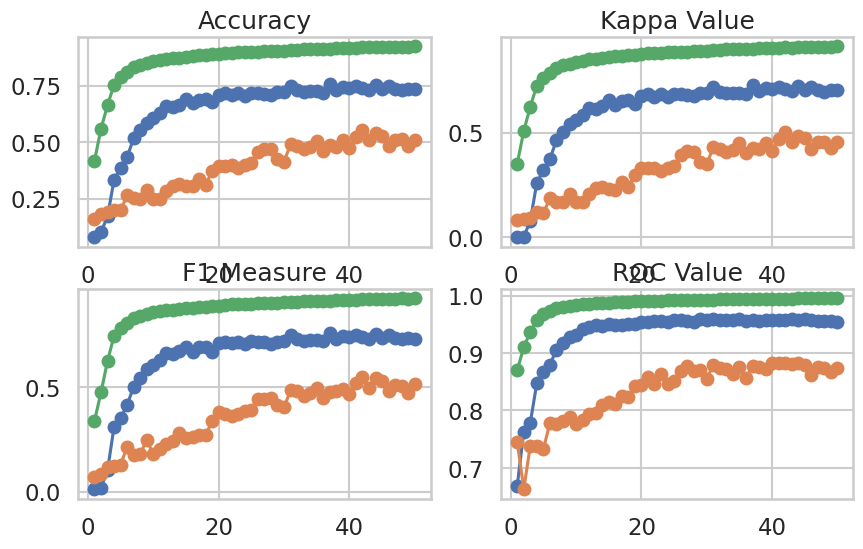

In [40]:


plt.figure(figsize=(10, 6))

plt.subplot(2, 2, 1)
plt.plot(rounds, [metric['accuracy'] for metric in flower_metrics], marker='o')
plt.plot(rounds, [metric['accuracy'] for metric in metrics], marker='o')
plt.plot(rounds, [metric for metric in fedn_accuracy], marker='o')
plt.title('Accuracy')

plt.subplot(2, 2, 2)
plt.plot(rounds, [metric['kappa'] for metric in flower_metrics], marker='o')
plt.plot(rounds, [metric['kappa'] for metric in metrics], marker='o')
plt.plot(rounds, [metric for metric in fedn_kappa], marker='o')
plt.title('Kappa Value')

plt.subplot(2, 2, 3)
plt.plot(rounds, [metric['f1'] for metric in flower_metrics], marker='o')
plt.plot(rounds, [metric['f1'] for metric in metrics], marker='o')
plt.plot(rounds, [metric for metric in fedn_f1], marker='o')

plt.title('F1 Measure')

plt.subplot(2, 2, 4)
plt.plot(rounds, [metric['roc'] for metric in flower_metrics], marker='o')
plt.plot(rounds, [metric['roc'] for metric in metrics], marker='o')
plt.plot(rounds, [metric for metric in fedn_roc], marker='o')

plt.title('ROC Value')

plt


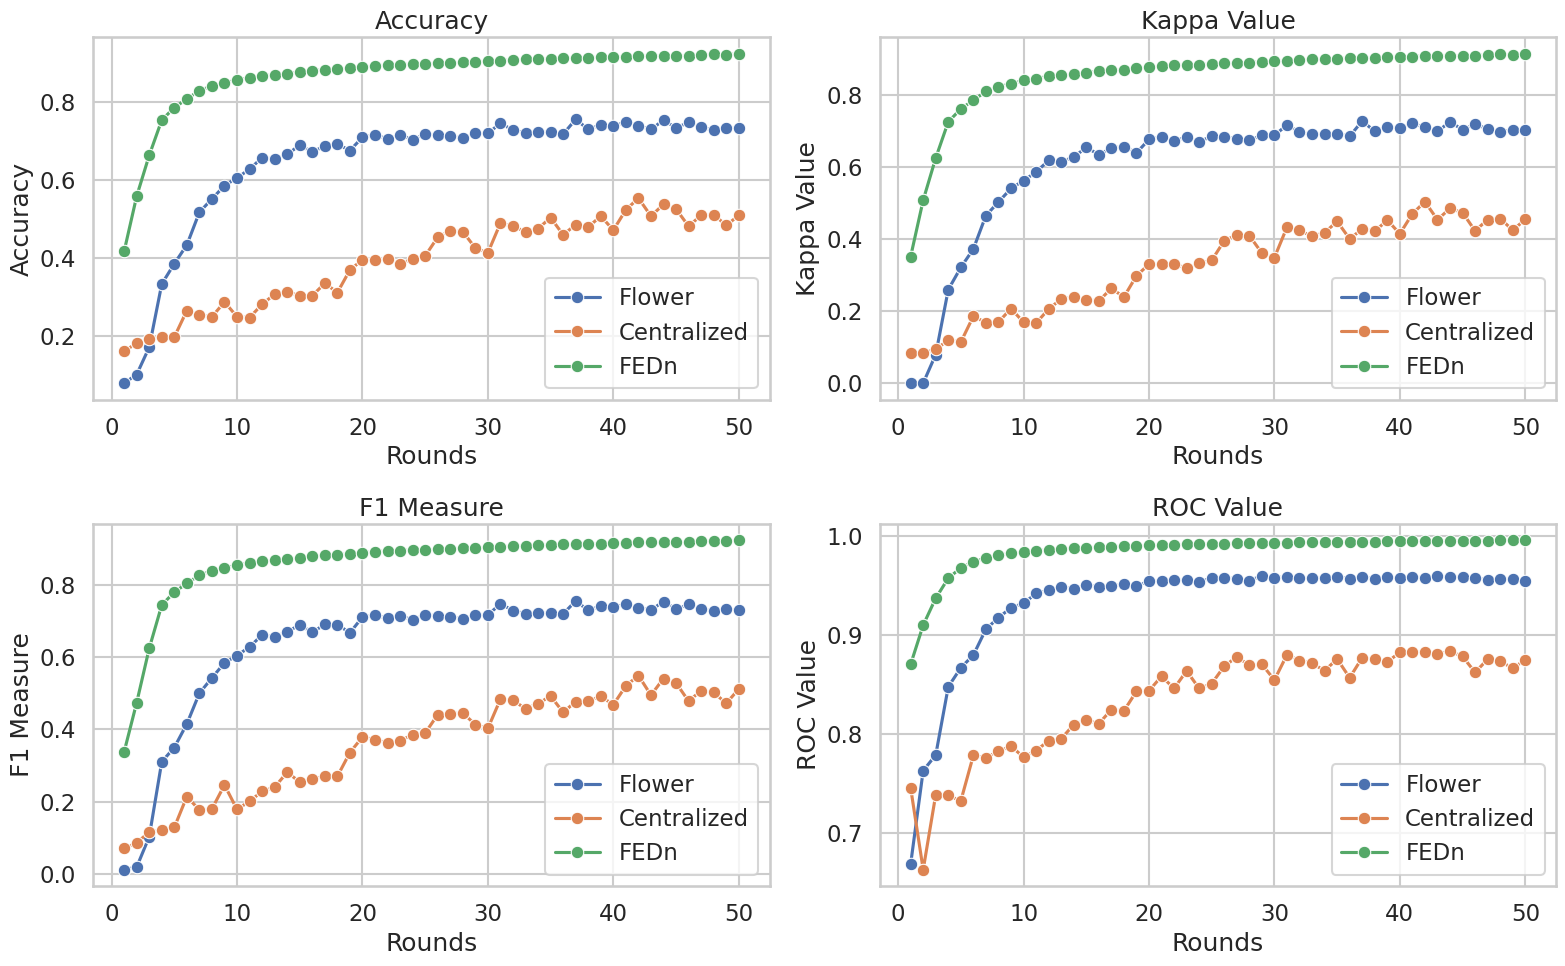

In [41]:
import seaborn as sns

sns.set(style='whitegrid', context='talk')

plt.figure(figsize=(16, 10))

# Accuracy plot
plt.subplot(2, 2, 1)
sns.lineplot(x=rounds, y=[metric['accuracy'] for metric in flower_metrics], marker='o', label='Flower')
sns.lineplot(x=rounds, y=[metric['accuracy'] for metric in metrics], marker='o', label='Centralized')
sns.lineplot(x=rounds, y=fedn_accuracy, marker='o', label='FEDn')
plt.title('Accuracy')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()

# Kappa plot
plt.subplot(2, 2, 2)
sns.lineplot(x=rounds, y=[metric['kappa'] for metric in flower_metrics], marker='o', label='Flower')
sns.lineplot(x=rounds, y=[metric['kappa'] for metric in metrics], marker='o', label='Centralized')
sns.lineplot(x=rounds, y=fedn_kappa, marker='o', label='FEDn')
plt.title('Kappa Value')
plt.xlabel('Rounds')
plt.ylabel('Kappa Value')
plt.legend()

# F1 Measure plot
plt.subplot(2, 2, 3)
sns.lineplot(x=rounds, y=[metric['f1'] for metric in flower_metrics], marker='o', label='Flower')
sns.lineplot(x=rounds, y=[metric['f1'] for metric in metrics], marker='o', label='Centralized')
sns.lineplot(x=rounds, y=fedn_f1, marker='o', label='FEDn')
plt.title('F1 Measure')
plt.xlabel('Rounds')
plt.ylabel('F1 Measure')
plt.legend()

# ROC Value plot
plt.subplot(2, 2, 4)
sns.lineplot(x=rounds, y=[metric['roc'] for metric in flower_metrics], marker='o', label='Flower')
sns.lineplot(x=rounds, y=[metric['roc'] for metric in metrics], marker='o', label='Centralized')
sns.lineplot(x=rounds, y=fedn_roc, marker='o', label='FEDn')
plt.title('ROC Value')
plt.xlabel('Rounds')
plt.ylabel('ROC Value')
plt.legend()

plt.tight_layout()
plt.show()